# Beam Waist Measurements

**Scott Prahl**

**March 2020, Version 2**

In [2]:
%matplotlib inline
import imageio
import numpy as np
import matplotlib.pyplot as plt

import laserbeamsize as lbs

def z_rayleigh(w0,lambda0):
    """
    Return the Rayleigh distance.
    Args:
        w0 : minimum beam radius [m]
        lambda0: wavelength of light [m]
    Returns:
        distance where irradiance drops by 1/2 [m]
    """
    return np.pi * w0**2/lambda0


def beam_radius(w0,z0,lambda0,z):
    """
    Return the beam radius at an axial location.
    Args:
        w0 : minimum beam radius [m]
        z0 : axial location of beam waist [m]
        lambda0: wavelength of light [m]
        z : axial location of desired beam radius [m]
    Returns:
        Beam radius [m]
    """
    return w0*np.sqrt(1+((z-z0)/z_rayleigh(w0,lambda0))**2)

pixel_size_mm = 3.75/1000           # pixel size in mm for the camera

## Gaussian Beam Propagation

It would seem that $w$ should stand for *width*, but it doesn't.  This means that $w$ is not the diameter but the radius.  Go figure.

### Beam waist 

In any case, the minimum beam radius as a Gaussian beam propagates is called $w_0$ and is located at $z_0$.  This is shown graphically below.

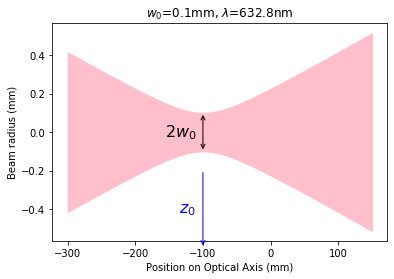

In [3]:
w0=0.1                    # radius of beam waist [mm]
z0=-100                   # z-axis position of beam waist [mm]
lambdaa=0.6328/1000       # again in mm
zR=z_rayleigh(w0,lambdaa) # Rayleigh Distance

z = np.linspace(-300,150,100)

plt.fill_between(z,-beam_radius(w0,z0,lambdaa,z),beam_radius(w0,z0,lambdaa,z),color='pink')

plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.1fmm, $\lambda$=%.1fnm"%(w0,1e6*lambdaa))
plt.annotate('$2w_0$',xy=(z0-10,0),ha='right',va='center', fontsize=16)
plt.annotate('',xy=(z0,w0),xytext=(z0,-w0),arrowprops=dict(arrowstyle="<->"))

plt.annotate('$z_0$',xy=(z0-10,-0.4),ha='right',va='center', fontsize=16,color='blue')
plt.annotate('',xy=(z0,-0.2),xytext=(z0,-0.6),arrowprops=dict(arrowstyle="<-",color='blue'))
#plt.ylim(-0.5,0.5)

plt.show()

### Rayleigh Length $z_R$

The Rayleigh length $z_R$ is 
$$
z_R=\pi w_0^2/\lambda
$$
and is the distance from the beam waist to the point where the beam radius has increased by a factor of $\sqrt{2}$ (and therefore the area has doubled or the irradiance (power/area) has dropped 50%).

### Beam Radius $w(z)$

The function $w(z)$ is the beam radius as a function of location $z$ along the axis. As seen above, when $z = z_0$ it reaches a minimum value $w_0$, called the beam waist. For a Gaussian beam propagating in free space, the beam radius at any point only depends on the waist $w_0$, its location $z_0$, and the wavelength.
$$
w(z)=w_0\sqrt{1+{(z-z_0)^2\over z_R^2}}
$$

The beam waist $w_0$ and its location at $z = z_0$ determine the beam size everywhere (assuming, of course, that the wavelength is known).

### Beam Divergence $\theta$

The beam divergence is defined as
$$
\theta=\lim_{z\rightarrow\infty}{w(z)\over z}={w_0\over z_R}
$$

The beam divergence and Rayleigh lengths are shown in the graph below.

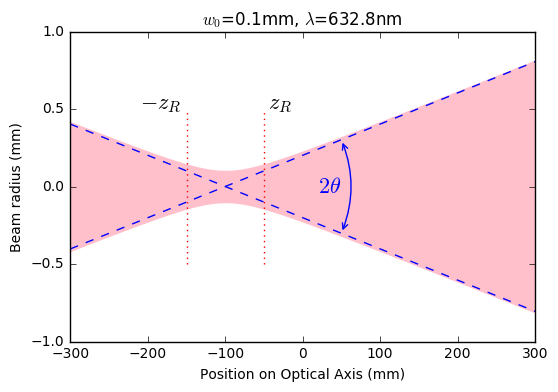

In [3]:
w0=0.1                    # radius of beam waist [mm]
z0=-100                   # z-axis position of beam waist [mm]
lambdaa=0.6328/1000       # again in mm
zR=z_rayleigh(w0,lambdaa) # Rayleigh Distance

theta = w0/zR
z = np.linspace(-300,300,100)
plt.fill_between(z,-beam_radius(w0,z0,lambdaa,z),beam_radius(w0,z0,lambdaa,z),color='pink')

plt.plot(z,theta*(z-z0),'--b')
plt.plot(z,-theta*(z-z0),'--b')
plt.plot([zR+z0,zR+z0],[-1/2,1/2],':r')
plt.plot([-zR+z0,-zR+z0],[-1/2,1/2],':r')

plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.1fmm, $\lambda$=%.1fnm"%(w0,1e6*lambdaa))
plt.annotate('$z_R$',xy=(0.9*(zR+z0),0.5),fontsize=16)
plt.annotate('$-z_R$',xy=(1.4*(-zR+z0),0.5),fontsize=16)

plt.annotate(r'$2\theta$',xy=(20,0),fontsize=16,va='center',color='blue')
plt.annotate('',xy=(50,0.30),xytext=(50,-0.30),arrowprops=dict(connectionstyle="arc3,rad=0.2", arrowstyle="<->",color='blue'))

plt.show()

## Experimentally determining beam parameters

Test with 12 different images of the beam taken at different axial positions. 

First, load the images and find the beam diameters dx and dy.

In [4]:
# pixel size in mm for the camera
pixel_size_mm = 3.75/1000           

# array of distances at which images were collected
z1 = [168,210,280,348,414,480,495,510,520,580,666,770] #mm

num = len(z1)
xc = np.empty(num)
yc = np.empty(num)
rx = np.empty(num)
ry = np.empty(num)
phi = np.empty(num)

#acquire centers and sizes for all the beam
for i in range(num):
    fn = "t-%dmm.pgm" % z1[i]
    test_image = imageio.imread(fn)      
    xc[i], yc[i], dx, dy, phi[i] = lbs.beam_size(test_image)
    rx[i] = dx/2
    ry[i] = dy/2

Plot these

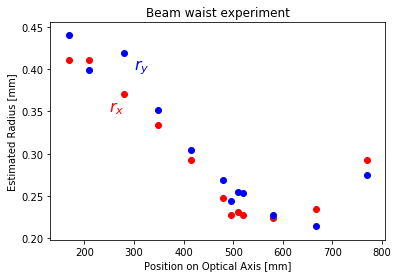

In [5]:
plt.scatter(z1,rx*pixel_size_mm, color='red')
plt.scatter(z1,ry*pixel_size_mm, color='blue')

plt.xlabel('Position on Optical Axis [mm]')
plt.ylabel('Estimated Radius [mm]')
plt.annotate('$r_x$', xy=(250,0.35),color='red',fontsize=16)
plt.annotate('$r_y$', xy=(300,0.40),color='blue',fontsize=16)
plt.title("Beam waist experiment")
plt.show()

Fit the data to theory by hand.  Best practice is to make measurements a couple of Rayleigh distances on each side of the beam waist.  This data does not have those points so automatic fitting routines work terrible.

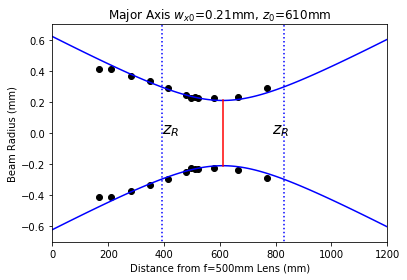

In [7]:
# Need array of data so we can plot theory
z = np.linspace(0,1200,100)          #mm

lambdaa = 632.8e-6  #mm
z0 = 610
w0 = 0.21
M2 = 1.0

zR = np.pi*w0**2/lambdaa  #mm

plt.scatter(z1, rx*pixel_size_mm, color='black')
plt.scatter(z1,-rx*pixel_size_mm, color='black')

rtop =  beam_radius(w0,z0,lambdaa,z)       
rbot = -beam_radius(w0,z0,lambdaa,z)

plt.plot(z,rtop,color='blue')
plt.plot(z,rbot,color='blue')
#plt.plot([0,1200],[0,0],':k')
plt.plot([z0,z0],[-w0,w0],color='red')
plt.plot([z0+zR,z0+zR],[-1,1],':b')
plt.plot([z0-zR,z0-zR],[-1,1],':b')

plt.xlabel("Distance from f=500mm Lens (mm)")
plt.ylabel("Beam Radius (mm)")
plt.title("Major Axis $w_{x0}$=%.2fmm, $z_0$=%.0fmm"%(w0,z0))
plt.annotate('$z_R$', (z0-zR,0.0), fontsize=16)
plt.annotate('$z_R$', (0.95*(z0+zR),0.0), fontsize=16)

plt.xlim(0,1200)
plt.ylim(-0.7,0.7)
plt.show()


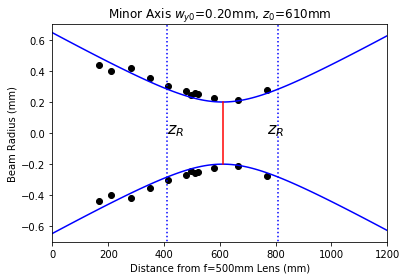

In [8]:
# Need array of data so we can plot theory
z = np.linspace(0,1200,100)          #mm

lambdaa = 632.8e-6  #mm
z0 = 610
w0 = 0.20
M2 = 1.0

zR = np.pi*w0**2/lambdaa  #mm

plt.scatter(z1, ry*pixel_size_mm, color='black')
plt.scatter(z1,-ry*pixel_size_mm, color='black')

rtop =  beam_radius(w0,z0,lambdaa,z)       
rbot = -beam_radius(w0,z0,lambdaa,z)

plt.plot(z,rtop,color='blue')
plt.plot(z,rbot,color='blue')
#plt.plot([0,1200],[0,0],':k')
plt.plot([z0,z0],[-w0,w0],color='red')
plt.plot([z0+zR,z0+zR],[-1,1],':b')
plt.plot([z0-zR,z0-zR],[-1,1],':b')

plt.xlabel("Distance from f=500mm Lens (mm)")
plt.ylabel("Beam Radius (mm)")
plt.title("Minor Axis $w_{y0}$=%.2fmm, $z_0$=%.0fmm"%(w0,z0))
plt.annotate('$z_R$', (z0-zR,0.0), fontsize=16)
plt.annotate('$z_R$', (0.95*(z0+zR),0.0), fontsize=16)

plt.xlim(0,1200)
plt.ylim(-0.7,0.7)
plt.show()

